In [12]:
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import cv2
import re
from PIL import Image



In [13]:
# Images in the ./Train_imgs are cropped from the experimental data

img_dir = os.listdir("./Train_imgs") 
img_list = []
for i in range(len(img_dir)):
    img_list.append(plt.imread("./Train_imgs" + f"/{img_dir[i]}"))

img_list_new =[] #New images after cropping the old images to required size

### Preparing the data for training 

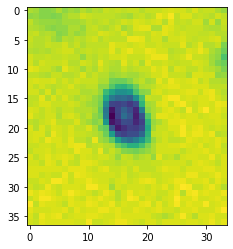

In [14]:
# Cropping the images again to required size manually (To keep the particle at center as much as possible)
# Do this only if required

#a = img_list[1]
#plt.imshow(a)

In [15]:
#img_list_new.append(a[10:30, 6:26])#

In [16]:
# Saving the new images as numpy files
os.makedirs("train_images", exist_ok=True)

count = 0
for img in img_list_new:
    
    np.save(f"./train_images/{count}.npy", img)
    count+=1

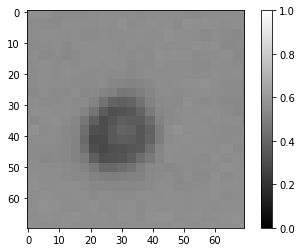

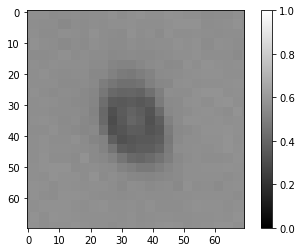

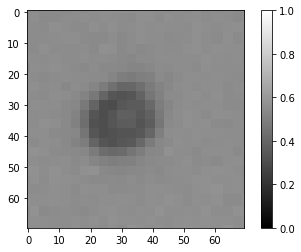

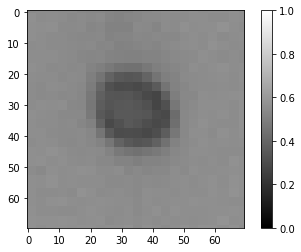

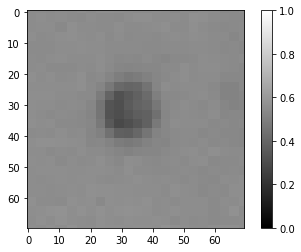

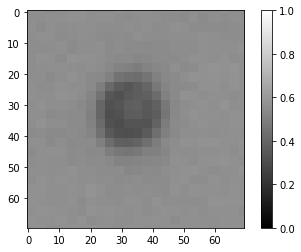

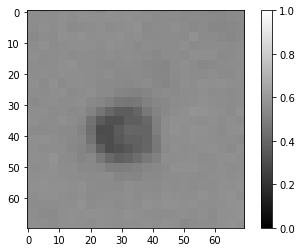

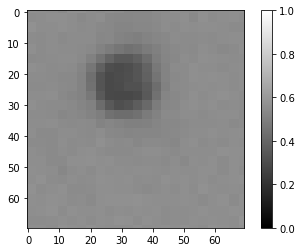

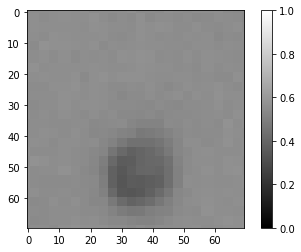

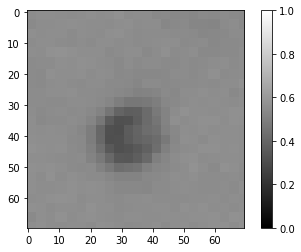

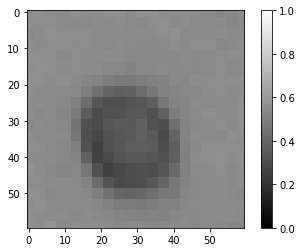

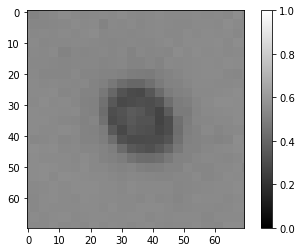

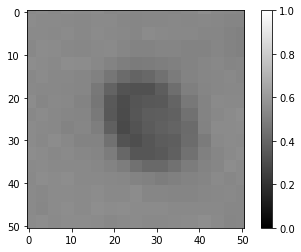

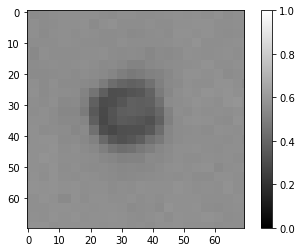

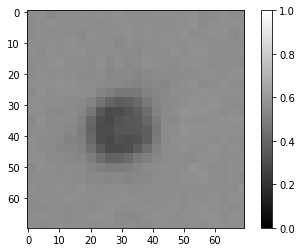

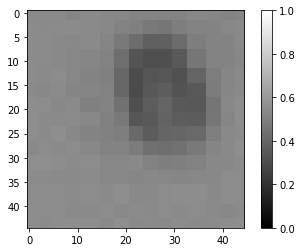

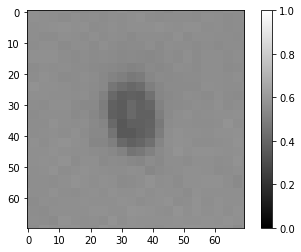

In [3]:
img_list = []

for fileName in os.listdir("./train_images") :
    im = np.load("./train_images/"+fileName)/255
    # upscale 3x since the resolution is low in the original image
    im = scipy.ndimage.zoom(im, 3, order=0)

    # crop to biggest square
    h, w = im.shape
    min_dim = min(h, w, 70)
    im = im[(h-min_dim)//2:(h-min_dim)//2+min_dim, (w-min_dim)//2:(w-min_dim)//2+min_dim]
    im = np.expand_dims(im, axis = 2)

    plt.imshow(im, cmap = "gray", vmin = 0, vmax =1)
    plt.colorbar()
    plt.show()

    img_list.append(im)
    

In [32]:
#Augmentations
import random
training_set = dt.Value(lambda: np.array(random.choice(img_list[:10])) ) >> \
     dt.Multiply(lambda: np.random.uniform(0.8, 1.2)) >> \
     dt.Add(lambda: np.random.randn() * 0.05) >> \
     dt.Gaussian(sigma=lambda: np.random.uniform(.01, .02))


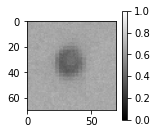

In [53]:
# Showing the training data
plt.figure(figsize=(2, 2))
plt.imshow(training_set.update().resolve(), cmap = "gray", vmin = 0, vmax = 1)
plt.colorbar()

In [54]:
#Generator
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    num_outputs = 2,  
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)

In [2]:
#Model
import tensorflow as tf
model = dt.models.LodeSTAR(input_shape=(None, None, 1), num_outputs=2)
model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

## Training

In [ ]:
#Training
with generator:
    
    model.fit(generator, epochs=50, steps_per_epoch=100)

In [93]:
model.save("./LodeSTAR_Network")

INFO:tensorflow:Assets written to: ./LodeSTAR_Network\assets


## Testing

In [3]:
model.load_weights("./LodeSTAR_Network")

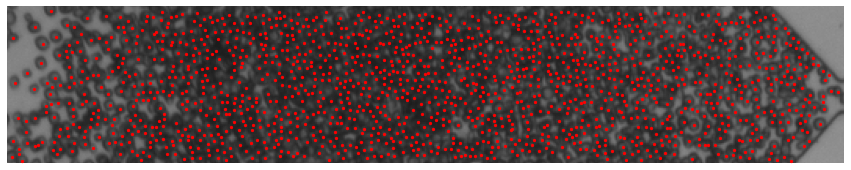

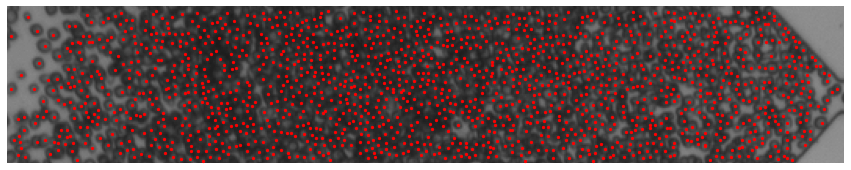

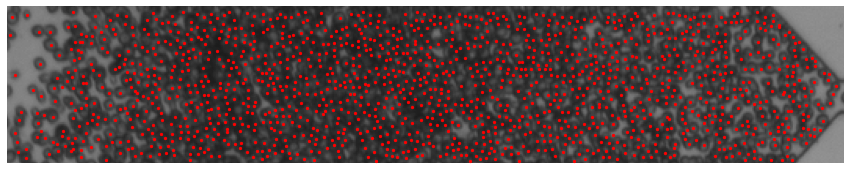

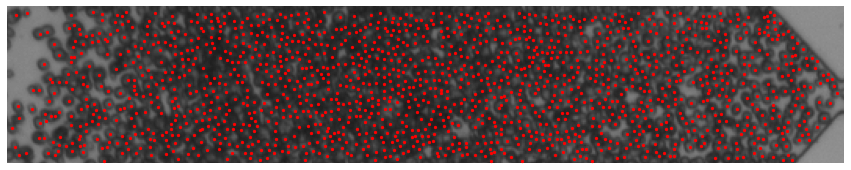

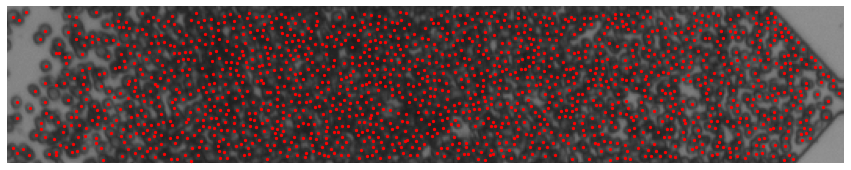

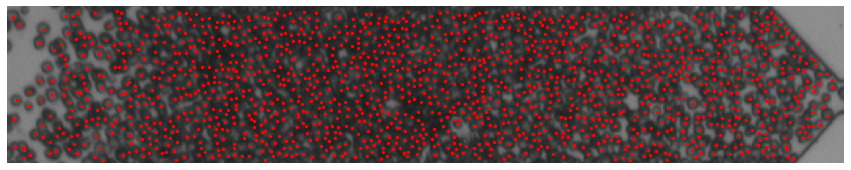

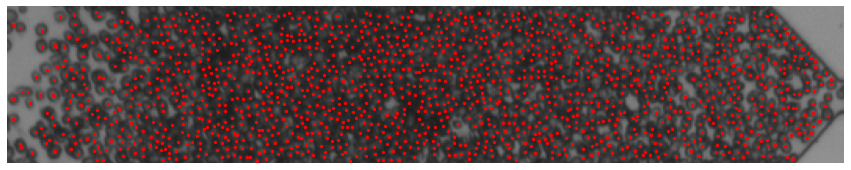

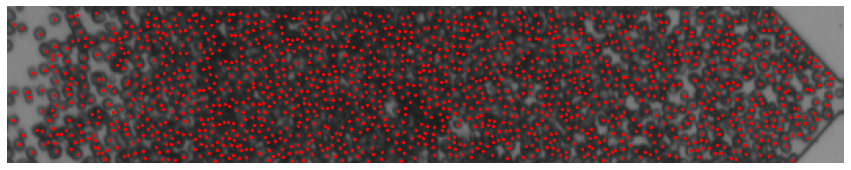

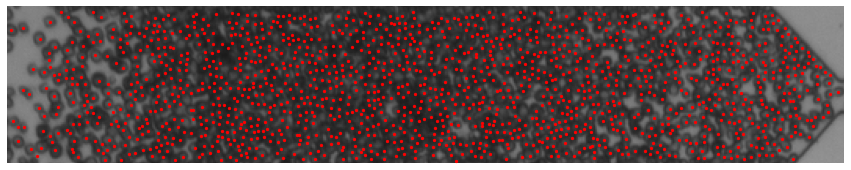

In [5]:
# May need to tune these to get optimal performance!
import scipy

# Parameters (May need to be tuned)
alpha = 0.3 
cutoff = 0.35 

test_img_dir = "./New sequence testing 4"

count = 0
detections = []

os.makedirs("results", exist_ok=True)
for i, fileName in enumerate(os.listdir(test_img_dir)):
    if count >= 10: #Please remove this if you need to test on all the images in the folder
        break
    
    img = np.array(Image.open(test_img_dir+"/"+fileName))/255

    # upscale img 3x
    img = scipy.ndimage.zoom(img, 3, order=0)

    img = np.expand_dims(img, axis = 2)
    pred, weights = model.predict(img[np.newaxis])
    score = model.get_detection_score(pred[0], weights[0], alpha=alpha, beta=1-alpha)
    detections.append(model.predict_and_detect(img[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="constant")[0])#1-alpha

    plt.figure(figsize=(15, 8))
    plt.imshow(img, cmap = "gray", vmin = 0, vmax = 1)
    plt.axis("off")
    plt.scatter(detections[count][:, 1], detections[count][:, 0],s = 5, color="r")

    plt.savefig(f'./results/{i}.png')
    plt.show()

    count += 1
    

In [5]:
# To make a video
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


image_folder = './results'
video_name = 'video.avi'

images = sorted_alphanumeric(os.listdir(image_folder))
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    
    video.write(cv2.imread(os.path.join(image_folder, image)))
    
cv2.destroyAllWindows()
video.release()